
# Neural Network Classification Project

================================================================================

A comprehensive implementation of feed-forward neural networks for image classification
using TensorFlow/Keras on the MNIST dataset.

Author: AKAKPO Koffi Moïse

Date: August 2025

Purpose: Machine Learning Internship Application - Task 3

In [ ]:
# installation de tensorflow
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
class NeuralNetworkClassifier:
    """
    A comprehensive neural network classifier with hyperparameter tuning capabilities.
    """

    def __init__(self, input_shape, num_classes):
        """
        Initialize the neural network classifier.

        Args:
            input_shape (tuple): Shape of input data
            num_classes (int): Number of output classes
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def create_model(self, hidden_layers=[128, 64], dropout_rate=0.2, learning_rate=0.001):
        """
        Create a feed-forward neural network architecture.

        Args:
            hidden_layers (list): List of hidden layer sizes
            dropout_rate (float): Dropout rate for regularization
            learning_rate (float): Learning rate for optimizer
        """
        model = keras.Sequential([
            layers.Flatten(input_shape=self.input_shape),
            layers.Dense(hidden_layers[0], activation='relu', name='hidden_1'),
            layers.Dropout(dropout_rate),
            layers.Dense(hidden_layers[1], activation='relu', name='hidden_2'),
            layers.Dropout(dropout_rate),
            layers.Dense(self.num_classes, activation='softmax', name='output')
        ])

        # Compile with appropriate optimizer and metrics
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, verbose=1):
        """
        Train the neural network with early stopping and learning rate scheduling.

        Args:
            X_train, y_train: Training data
            X_val, y_val: Validation data
            epochs (int): Maximum number of epochs
            batch_size (int): Batch size for training
            verbose (int): Verbosity level
        """
        # Callbacks for better training
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            )
        ]

        # Train the model
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )

        return self.history

    def evaluate(self, X_test, y_test):
        """
        Evaluate the model on test data.

        Args:
            X_test, y_test: Test data

        Returns:
            dict: Evaluation metrics
        """
        # Get predictions
        y_pred_proba = self.model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Calculate metrics
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)

        # Classification report
        class_report = classification_report(y_test, y_pred, output_dict=True)

        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)

        return {
            'test_loss': test_loss,
            'test_accuracy': test_accuracy,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'classification_report': class_report,
            'confusion_matrix': conf_matrix
        }

def load_and_preprocess_data():
    """
    Load and preprocess the MNIST dataset.

    Returns:
        tuple: Preprocessed training and testing data
    """
    print("Loading MNIST dataset...")

    # Load data
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # Normalize pixel values to [0, 1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    # Split training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Image shape: {X_train.shape[1:]}")
    print(f"Number of classes: {len(np.unique(y_train))}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def visualize_data(X_train, y_train):
    """
    Visualize sample images from the dataset.
    """
    plt.figure(figsize=(12, 8))

    # Plot sample images
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X_train[i], cmap='gray')
        plt.title(f'Label: {y_train[i]}')
        plt.axis('off')

    plt.suptitle('Sample Images from MNIST Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Plot class distribution
    plt.figure(figsize=(10, 6))
    unique, counts = np.unique(y_train, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel('Digit Class')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Training Set')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_training_history(history):
    """
    Plot training and validation metrics.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plot confusion matrix heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    """
    Perform hyperparameter tuning to find optimal parameters.
    """
    print("Starting hyperparameter tuning...")

    # Define hyperparameter grid
    param_grid = {
        'learning_rate': [0.001, 0.01, 0.0001],
        'batch_size': [32, 64, 128],
        'hidden_layers': [[64, 32], [128, 64], [256, 128]]
    }

    best_accuracy = 0
    best_params = {}
    results = []

    # Grid search
    for lr in param_grid['learning_rate']:
        for batch_size in param_grid['batch_size']:
            for hidden_layers in param_grid['hidden_layers']:
                print(f"Testing: LR={lr}, Batch={batch_size}, Hidden={hidden_layers}")

                # Create and train model
                nn = NeuralNetworkClassifier(input_shape=(28, 28), num_classes=10)
                nn.create_model(hidden_layers=hidden_layers, learning_rate=lr)

                history = nn.train(X_train, y_train, X_val, y_val,
                                 epochs=20, batch_size=batch_size, verbose=0)

                # Get best validation accuracy
                val_accuracy = max(history.history['val_accuracy'])

                results.append({
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'hidden_layers': str(hidden_layers),
                    'val_accuracy': val_accuracy
                })

                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'hidden_layers': hidden_layers
                    }

    # Convert results to DataFrame for better visualization
    results_df = pd.DataFrame(results)
    print("\nHyperparameter Tuning Results:")
    print(results_df.sort_values('val_accuracy', ascending=False))

    print(f"\nBest Parameters: {best_params}")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

    return best_params, results_df

def main():
    """
    Main execution function.
    """
    print("=" * 60)
    print("NEURAL NETWORK CLASSIFICATION PROJECT")
    print("=" * 60)

    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Load and preprocess data
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = load_and_preprocess_data()

    # Visualize data
    print("\n1. Data Visualization")
    visualize_data(X_train, y_train)

    # Hyperparameter tuning
    print("\n2. Hyperparameter Tuning")
    best_params, tuning_results = hyperparameter_tuning(X_train, y_train, X_val, y_val)

    # Train final model with best parameters
    print("\n3. Training Final Model")
    final_model = NeuralNetworkClassifier(input_shape=(28, 28), num_classes=10)
    final_model.create_model(
        hidden_layers=best_params['hidden_layers'],
        learning_rate=best_params['learning_rate']
    )

    print("\nModel Architecture:")
    final_model.model.summary()

    # Train with best parameters
    history = final_model.train(
        X_train, y_train, X_val, y_val,
        epochs=100,
        batch_size=best_params['batch_size']
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model
    print("\n4. Model Evaluation")
    results = final_model.evaluate(X_test, y_test)

    print(f"Test Accuracy: {results['test_accuracy']:.4f}")
    print(f"Test Loss: {results['test_loss']:.4f}")

    # Detailed classification report
    print("\nClassification Report:")
    class_names = [str(i) for i in range(10)]
    print(classification_report(y_test, results['predictions'], target_names=class_names))

    # Plot confusion matrix
    plot_confusion_matrix(results['confusion_matrix'], class_names)

    # Display some predictions
    print("\n5. Sample Predictions")
    plt.figure(figsize=(15, 8))
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(X_test[i], cmap='gray')
        predicted_class = results['predictions'][i]
        confidence = results['probabilities'][i][predicted_class] * 100
        true_class = y_test[i]

        color = 'green' if predicted_class == true_class else 'red'
        plt.title(f'True: {true_class}, Pred: {predicted_class}\nConf: {confidence:.1f}%',
                 color=color)
        plt.axis('off')

    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Summary
    print("\n" + "=" * 60)
    print("PROJECT SUMMARY")
    print("=" * 60)
    print(f"✅ Dataset: MNIST (70,000 handwritten digits)")
    print(f"✅ Model: Feed-forward Neural Network")
    print(f"✅ Best Architecture: {best_params['hidden_layers']} hidden layers")
    print(f"✅ Best Learning Rate: {best_params['learning_rate']}")
    print(f"✅ Best Batch Size: {best_params['batch_size']}")
    print(f"✅ Final Test Accuracy: {results['test_accuracy']:.4f}")
    print(f"✅ Training completed with early stopping and LR scheduling")
    print("=" * 60)



NEURAL NETWORK CLASSIFICATION PROJECT
Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set: 48000 samples
Validation set: 12000 samples
Test set: 10000 samples
Image shape: (28, 28)
Number of classes: 10

1. Data Visualization


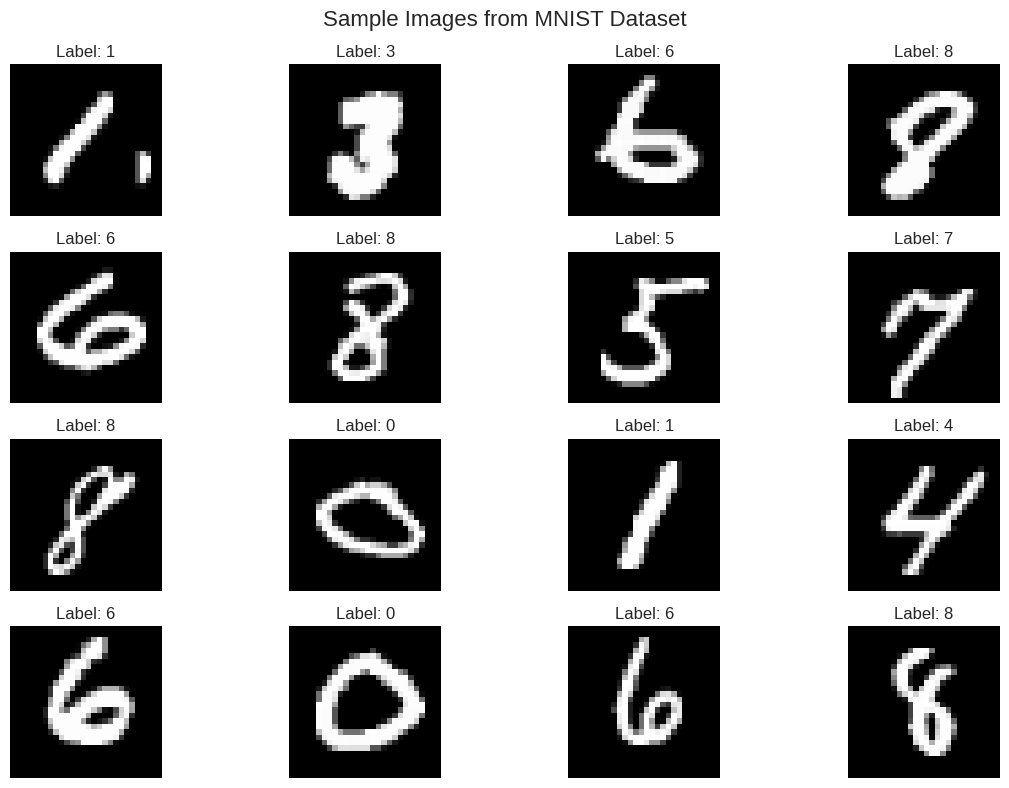

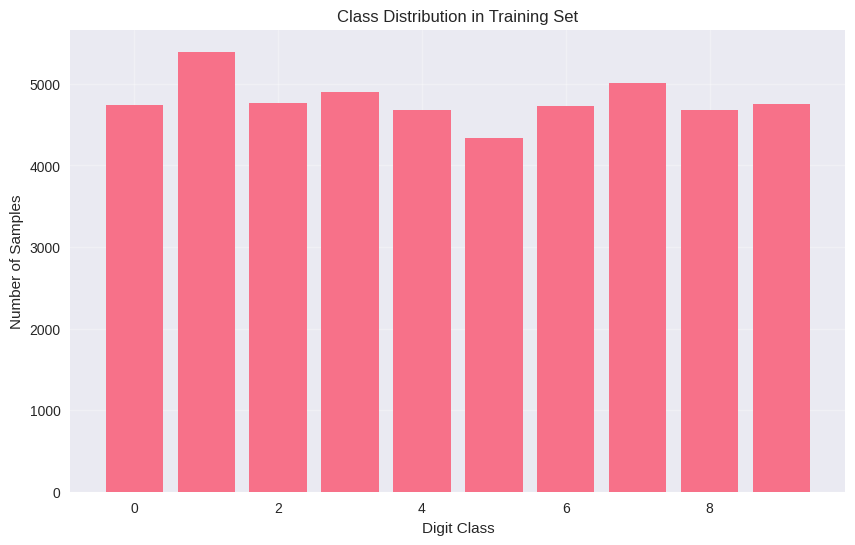


2. Hyperparameter Tuning
Starting hyperparameter tuning...
Testing: LR=0.001, Batch=32, Hidden=[64, 32]

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Restoring model weights from the end of the best epoch: 20.
Testing: LR=0.001, Batch=32, Hidden=[128, 64]

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 14.
Testing: LR=0.001, Batch=32, Hidden=[256, 128]

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
Testing: LR=0.001, Batch=64, Hidden=[64, 32]
Restoring model weights from the end of the best epoch: 18.
Testing: LR=0.001, Batch=64, Hidden=[128, 64]

Epoch 18: ReduceLROnPlateau reducing learning rate to 0

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_27 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8360 - loss: 0.5481 - val_accuracy: 0.9583 - val_loss: 0.1387 - learning_rate: 0.0010
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9535 - loss: 0.1559 - val_accuracy: 0.9656 - val_loss: 0.1108 - learning_rate: 0.0010
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9674 - loss: 0.1071 - val_accuracy: 0.9703 - val_loss: 0.0961 - learning_rate: 0.0010
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9731 - loss: 0.0837 - val_accuracy: 0.9718 - val_loss: 0.0961 - learning_rate: 0.0010
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9795 - loss: 0.0674 - val_accuracy: 0.9768 - val_loss: 0.0859 - learning_rate: 0.0010
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9815 - loss: 0.0571 - val_accuracy: 0.9767 - val_loss: 0.0888 - learning_rate: 0.0010
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9836 - loss: 0.

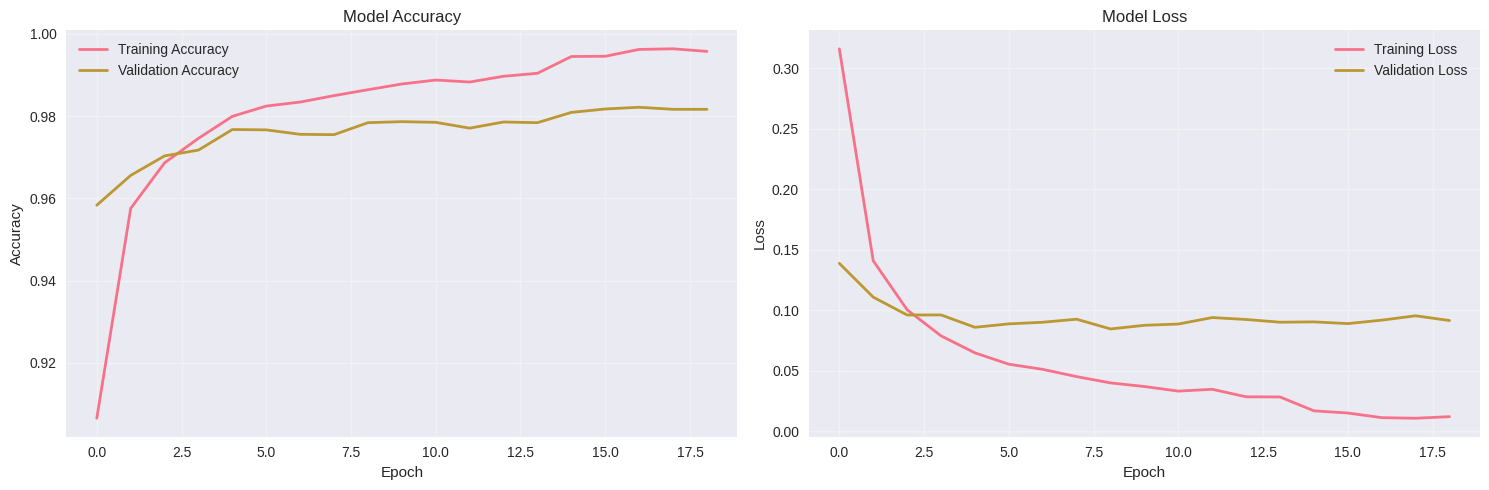


4. Model Evaluation
Test Accuracy: 0.9810
Test Loss: 0.0727

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.97      0.98      0.97      1028
           8       0.96      0.98      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



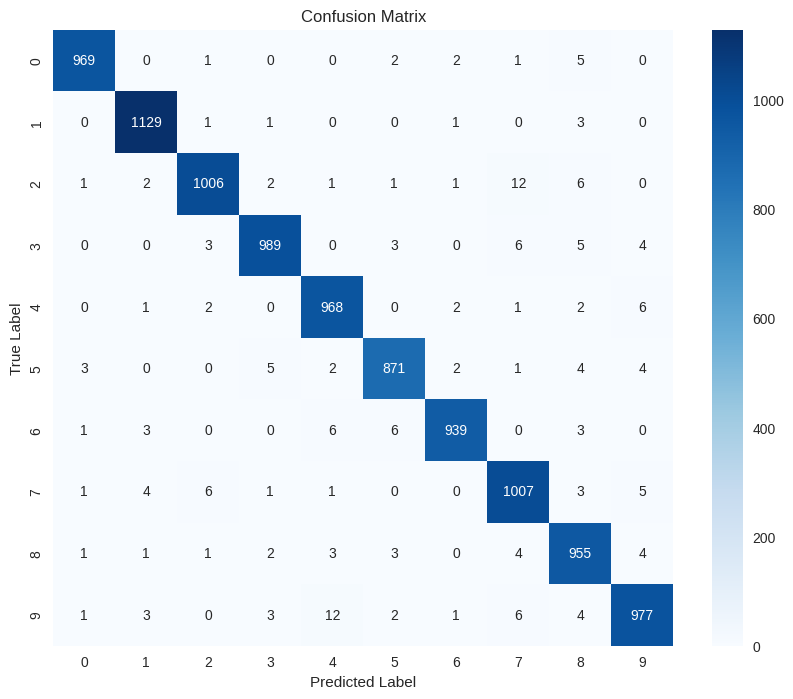


5. Sample Predictions


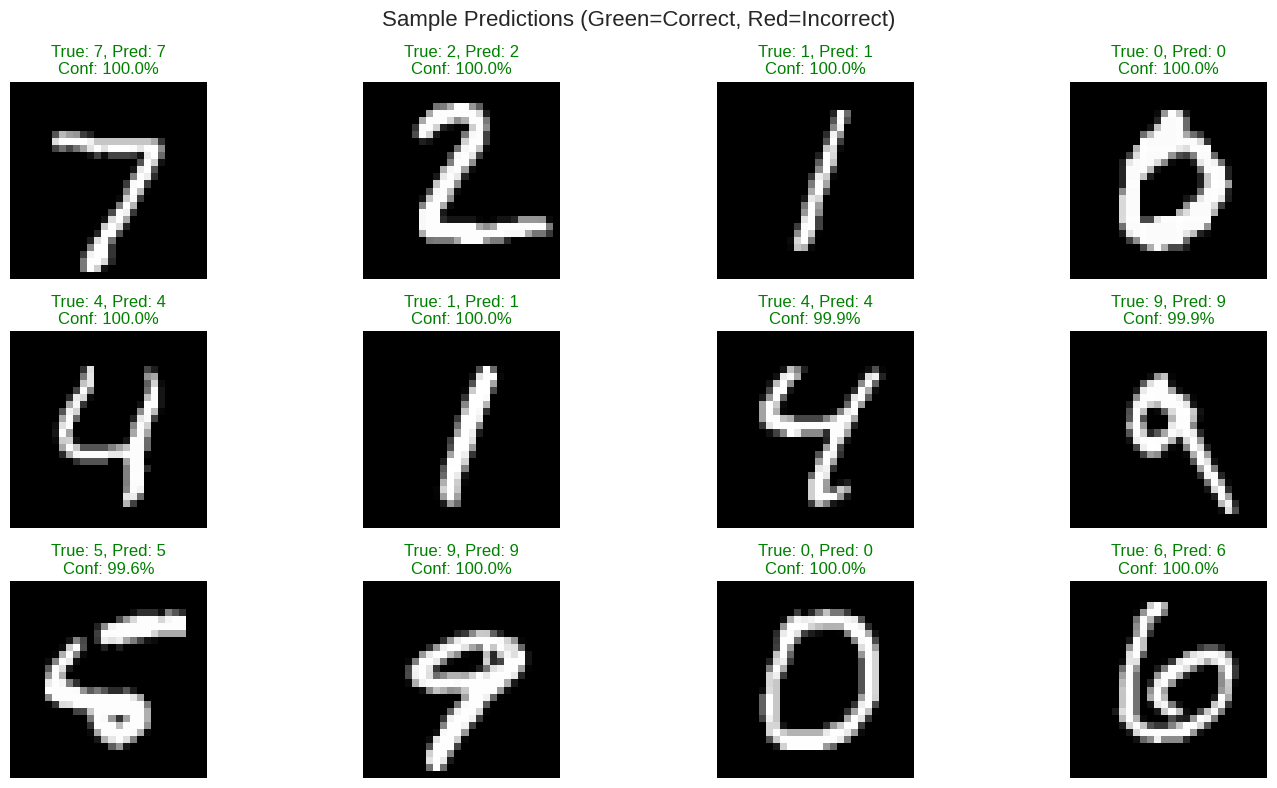


PROJECT SUMMARY
✅ Dataset: MNIST (70,000 handwritten digits)
✅ Model: Feed-forward Neural Network
✅ Best Architecture: [256, 128] hidden layers
✅ Best Learning Rate: 0.001
✅ Best Batch Size: 64
✅ Final Test Accuracy: 0.9810
✅ Training completed with early stopping and LR scheduling


In [ ]:
if __name__ == "__main__":
    main()